In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
import sys
from os.path import join
import math
import matplotlib.pyplot as plt

sys.path.insert(0, '/'.join(sys.path[0].split('/')[:-1] + ['scripts']))
from sequential_model import *

In [3]:
#export
class Dataset():
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
    
    def __repr__(self):
        return f'(Dataset) x: {tuple(self.x_data.shape)}, y: {tuple(self.y_data.shape)}'
    
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, i):
        return self.x_data[i], self.y_data[i]

In [4]:
#export
class Sampler():
    def __init__(self, size, batch_size, shuffle):
        self.size = size
        self.batch_size = batch_size
        self.shuffle = shuffle
    
    def __iter__(self):
        self.idxs = torch.randperm(self.size) if self.shuffle else torch.arange(self.size)
        for i in range(0, self.size, self.batch_size):
            yield self.idxs[i: i+self.batch_size]
    
    def __repr__(self):
        return f'(Sampler) total: {self.size}, batch_size: {self.batch_size}, shuffle: {self.shuffle}'
        
    def __len__(self):
        return self.batch_size
            
def collate(batch):
    x_batch, y_batch = zip(*batch)
    return torch.stack(x_batch), torch.stack(y_batch)

In [5]:
#export
class DataLoader():
    def __init__(self, dataset, sampler, collate_fn=collate):
        self.dataset = dataset
        self.sampler = sampler
        self.collate_fn = collate_fn
        
    def __iter__(self):
        for idxs in self.sampler:
            yield self.collate_fn([self.dataset[i] for i in idxs])
    
    def __repr__(self):
        return f'(DataLoader) \n\t\t{self.dataset}\n\t\t{self.sampler}'
        
    def __len__(self):
        return math.ceil(len(self.dataset) / len(self.sampler))

class DataBunch():
    def __init__(self, train_dl, valid_dl):
        self.train_dl = train_dl
        self.valid_dl = valid_dl
    
    @property
    def train_ds(self):
        return self.train_dl.dataset
    
    @property
    def valid_ds(self):
        return self.valid_dl.dataset
    
    def __repr__(self):
        return f'(DataBunch) \n\t{self.train_dl}\n\t{self.valid_dl}'
        
    def __len__(self):
        return len(self.train_dl)

In [6]:
#export
def compute_accuracy(pre, tar):
    return (torch.argmax(pre, dim=1) == tar).float().mean()

In [7]:
#export
class Optimizer():
    def __init__(self, parameters, learning_rate):
        self.parameters = parameters
        self.learning_rate = learning_rate
    
    def __repr__(self):
        return f'(Optimizer) num_params: {len(self.parameters)}, learning_rate: {self.learning_rate}'
        
    def step(self):
        for parameter in self.parameters:
            parameter.step(self.learning_rate)
    
    def zero_grad(self):
        for parameter in self.parameters:
            parameter.zero_grad()

In [8]:
#export
def get_data_bunch(x_train, y_train, x_valid, y_valid, batch_size):
    train_ds = Dataset(x_train, y_train)
    valid_ds = Dataset(x_valid, y_valid)
    train_dl = DataLoader(train_ds, Sampler(len(train_ds), batch_size, True))
    valid_dl = DataLoader(valid_ds, Sampler(len(valid_ds), batch_size*2, False)) # twice batch size (no backprop)
    return DataBunch(train_dl, valid_dl)

def get_model(data_bunch, learning_rate=0.1, num_hidden=50):
    in_dim = data_bunch.train_ds.x_data.shape[1]
    out_dim = int(max(data_bunch.train_ds.y_data) + 1)
    model = Sequential(Linear(in_dim, num_hidden), ReLU(), Linear(num_hidden, out_dim, end=True))
    return model, Optimizer(list(model.parameters()), learning_rate)

class Learner():
    def __init__(self, model, optimizer, loss_fn, data_bunch):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.data_bunch = data_bunch
    
    def __repr__(self):
        return f'{self.data_bunch}\n{self.model}\n{self.loss_fn}\n{self.optimizer}'

In [9]:
#export
def fit(num_epochs, learner):
    accuracies = []
    losses = []
    
    for epoch in range(1, num_epochs+1):
        for x_batch, y_batch in learner.data_bunch.train_dl:
            pred = learner.model(x_batch)
            loss = learner.loss_fn(pred, y_batch)
            
            learner.loss_fn.backward()
            learner.model.backward()
            
            learner.optimizer.step()
            learner.optimizer.zero_grad()
            
        count = accuracy = loss = 0
        for x_batch, y_batch in learner.data_bunch.valid_dl:
            pred = learner.model(x_batch)
            accuracy += compute_accuracy(pred, y_batch)
            loss += learner.loss_fn(pred, y_batch)
            count += 1
        accuracy /= count
        loss /= count
        
        accuracies.append(accuracy)
        losses.append(loss)
        print(f'Epoch {epoch}    Accuracy {round(accuracy.item(), 3)}    Loss {round(loss.item(), 3)}')
    
    return accuracies, losses

In [10]:
num_hidden = 50
batch_size = 64
num_epochs = 20
learning_rate = 0.1

data_bunch = get_data_bunch(*get_mnist_data(), batch_size)
model, optimizer = get_model(data_bunch, learning_rate, num_hidden)
loss_fn = CrossEntropy()
learner = Learner(model, optimizer, loss_fn, data_bunch)
learner

(DataBunch) 
	(DataLoader) 
		(Dataset) x: (50000, 784), y: (50000,)
		(Sampler) total: 50000, batch_size: 64, shuffle: True
	(DataLoader) 
		(Dataset) x: (10000, 784), y: (10000,)
		(Sampler) total: 10000, batch_size: 128, shuffle: False
(Sequential)
	(Layer1) Linear(784, 50)
	(Layer2) ReLU()
	(Layer3) Linear(50, 10)
(CrossEntropy)
(Optimizer) num_params: 4, learning_rate: 0.1

In [11]:
accuracies, losses = fit(num_epochs, learner)

Epoch 1    Accuracy 0.951    Loss 0.16
Epoch 2    Accuracy 0.959    Loss 0.137
Epoch 3    Accuracy 0.955    Loss 0.142
Epoch 4    Accuracy 0.951    Loss 0.16
Epoch 5    Accuracy 0.971    Loss 0.1
Epoch 6    Accuracy 0.968    Loss 0.109
Epoch 7    Accuracy 0.972    Loss 0.095
Epoch 8    Accuracy 0.972    Loss 0.091
Epoch 9    Accuracy 0.959    Loss 0.15
Epoch 10    Accuracy 0.972    Loss 0.094
Epoch 11    Accuracy 0.972    Loss 0.097
Epoch 12    Accuracy 0.97    Loss 0.104
Epoch 13    Accuracy 0.974    Loss 0.096
Epoch 14    Accuracy 0.971    Loss 0.101
Epoch 15    Accuracy 0.972    Loss 0.105
Epoch 16    Accuracy 0.973    Loss 0.098
Epoch 17    Accuracy 0.973    Loss 0.101
Epoch 18    Accuracy 0.971    Loss 0.111
Epoch 19    Accuracy 0.971    Loss 0.113
Epoch 20    Accuracy 0.972    Loss 0.11


In [12]:
#export
def plot(data, label):
    plt.plot(list(range(1,len(data)+1)), data)
    plt.xlabel('epoch')
    plt.ylabel(label)
    plt.xticks(list(range(1,len(data)+1)))
    plt.show()

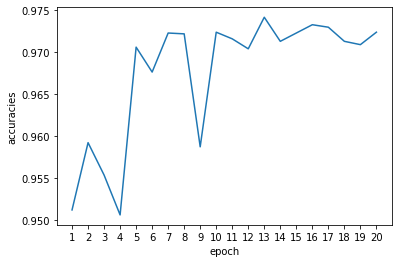

In [13]:
plot(accuracies, 'accuracies')

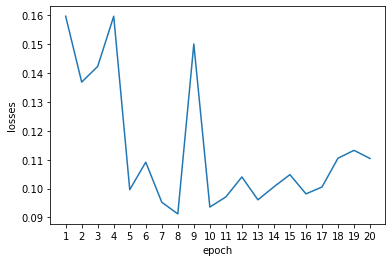

In [14]:
plot(losses, 'losses')